# Human Activity Recognition
Credit to:
* https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition
* https://github.com/cwi-dis/mobile-har-tutorial

In [1]:
import tensorflow as tf

import scipy.io
import sklearn
import sklearn.metrics

import pandas as pd
import numpy as np
#import matplotlib
import matplotlib.pyplot as plt
#import matplotlib.colors as colors
#import matplotlib.cm
import pickle

import os

2024-02-10 17:05:06.473370: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-10 17:05:07.575788: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### GPU and CPU settings
If GPU is not available, comment out the bottom block.

In [2]:
if True:
    # Enter either 0 or 1 below to select the GPU to use
    os.environ["CUDA_VISIBLE_DEVICES"]="0"

    physical_devices = tf.config.experimental.list_physical_devices('GPU')
    tf.config.set_visible_devices(physical_devices[0], 'GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

### Config your ConvLSTM

In [3]:
## UNCOMMENT below line for segmenting the signal in overlapping windows of 90 samples with 50% overlap
# segments, labels, subjects = segment_signal(df)

## COMMENT below segments + labels files if you want to segment afresh . open a file, where you stored the pickled data
segments = pickle.load(open('./data/segments_90_logo.p', 'rb'), encoding='latin1')
labels = pickle.load(open('./data/labels_90_logo.p','rb'), encoding='latin1')
subjects = pickle.load(open('./data/subjects_90_logo.p','rb'),encoding='latin1')
subjects = subjects.astype(int)

## dump information to that file (UNCOMMENT to save fresh segmentation!)
# pickle.dump(segments, open( './data/segments_90_logo.p','wb'))
# pickle.dump(labels, open( './data/labels_90_logo.p','wb'))
# pickle.dump(subjects, open( './data/subjects_90_logo.p','wb'))

# segments, labels, subjects = segment_signal(df)

groups = np.array(subjects)

## defining parameters for the input and network layers
## we are treating each segmeent or chunk as a 2D image (90 X 3)
numOfSamplesInWindow = segments.shape[1]
numOfChannels = segments.shape[2]

## reshaping the data for network input
reshapedSegments = segments.reshape(segments.shape[0], numOfSamplesInWindow, numOfChannels, 1)
## (observations, timesteps, features (x,y,z), channels)

# categorically defining the classes of the activities
labels = np.asarray(pd.get_dummies(labels),dtype = np.int8)

In [4]:
reshapedSegments.shape

(62476, 90, 6, 1)

In [5]:
lstPIds = sorted(set(subjects.astype(int)))
np.random.seed(42)
np.random.shuffle(lstPIds)
splitTrain = .7
splitVal = .2
splitTest = .1
splitTrainAmount = int(np.round(len(lstPIds)*splitTrain))
splitValAmount = int(np.round(len(lstPIds)*splitVal)) + splitTrainAmount
splitTestAmount = int(np.round(len(lstPIds)*splitTest)) + splitValAmount
lstPIdsTrain = lstPIds[:splitTrainAmount]
lstPIdsVal =  lstPIds[splitTrainAmount:splitValAmount]
lstPIdsTest = lstPIds[splitValAmount:]
lstPIdsTrain, lstPIdsVal, lstPIdsTest

([10, 12, 1, 13, 6, 9, 3, 2, 14, 5], [8, 11, 4], [7])

In [6]:
x_train = reshapedSegments[np.isin(subjects, lstPIdsTrain)]
x_val = reshapedSegments[np.isin(subjects, lstPIdsVal)]
x_test = reshapedSegments[np.isin(subjects, lstPIdsTrain)]

y_train_one_hot = labels[np.isin(subjects, lstPIdsTrain)]
y_val_one_hot = labels[np.isin(subjects, lstPIdsVal)]
y_test_one_hot = labels[np.isin(subjects, lstPIdsTrain)]

#x_train = np.expand_dims(x_train, 1)
#x_val = np.expand_dims(x_val, 1)
#x_test = np.expand_dims(x_test, 1)
#
#y_train_one_hot = np.expand_dims(y_train_one_hot, 1)
#y_val_one_hot = np.expand_dims(y_val_one_hot, 1)
#y_test_one_hot = np.expand_dims(y_test_one_hot, 1)


In [7]:
np.expand_dims(x_train,-1).shape

(45511, 90, 6, 1, 1)

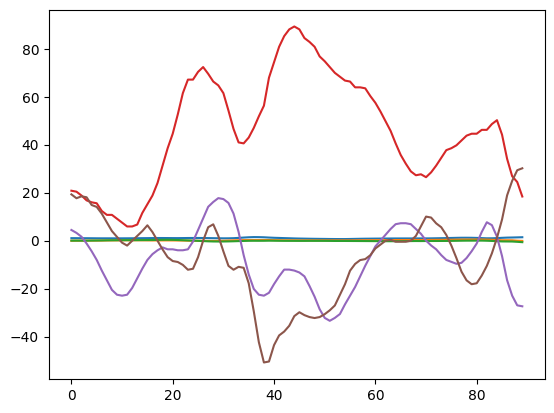

In [8]:
plt.plot(x_train[0].reshape(90,-1))
plt.show()

In [9]:
# number of epochs
Epochs = 2

batch_size = 32

## ConvLSTM net hyperparameters
numChannels = 1
numFilters = 128 # number of filters in Conv2D layer
# kernal size of the Conv2D layer
kernalSize1 = 2
# max pooling window size
poolingWindowSz = 2
# number of filters in fully connected layers
numNueronsFCL1 = 128
numNueronsFCL2 = 128

# number of total classes
numClasses = labels.shape[1]
# dropout ratio for dropout layer
dropOutRatio = 0.2

## number of total clases
numClasses = labels.shape[1]
print(labels.shape)
print(numClasses)

(62476, 12)
12


In [10]:

inputs = tf.keras.layers.Input(shape=(numOfSamplesInWindow, numOfChannels, 1), name="input")
layer = tf.keras.layers.ConvLSTM1D(numFilters, kernalSize1)(inputs)
layer = tf.keras.layers.Flatten()(layer)
layer = tf.keras.layers.Dense(numNueronsFCL1, activation='relu')(layer)
layer = tf.keras.layers.Dense(numNueronsFCL2, activation='relu')(layer)
output = tf.keras.layers.Dense(numClasses, activation='softmax')(layer)

model = tf.keras.Model(inputs=inputs, outputs=output)


## Compiling the model to generate a model
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
model.summary()

2024-02-10 17:05:15.200876: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22888 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:62:00.0, compute capability: 7.0


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 90, 6, 1)]        0         
                                                                 
 conv_lstm1d (ConvLSTM1D)    (None, 5, 128)            132608    
                                                                 
 flatten (Flatten)           (None, 640)               0         
                                                                 
 dense (Dense)               (None, 128)               82048     
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 12)                1548      
                                                                 
Total params: 232,716
Trainable params: 232,716
Non-trainable

### Train, evaluate & save your network

In [11]:
history = model.fit(x_train,
                    y_train_one_hot,
                    validation_data=(x_val, y_val_one_hot),
                    epochs=Epochs,
                    batch_size=batch_size,
                    verbose=1)

Epoch 1/2


2024-02-10 17:05:19.826790: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2024-02-10 17:05:20.282150: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7fc0c0008b60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-10 17:05:20.282211: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2024-02-10 17:05:20.294616: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-10 17:05:20.500601: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1423/1423 [==============================] - 755s 526ms/step - loss: 0.8266 - accuracy: 0.6990 - val_loss: 1.1959 - val_accuracy: 0.6133
Epoch 2/2
1423/1423 [==============================] - 746s 524ms/step - loss: 0.5211 - accuracy: 0.8062 - val_loss: 1.0496 - val_accuracy: 0.6453


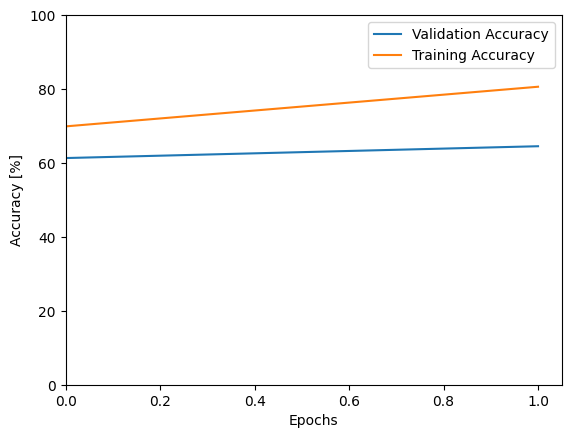

In [12]:
plt.plot(np.array(history.history['val_accuracy'])*100, label="Validation Accuracy")
plt.plot(np.array(history.history['accuracy'])*100, label="Training Accuracy")
plt.ylabel("Accuracy [%]")
plt.xlabel("Epochs")
plt.ylim(0,100)
plt.xlim(0,)
plt.legend()

In [13]:
# use model for inference to get test accuracy
y_val_pred = model.predict(x_val)
y_val_pred = np.argmax(y_val_pred, axis=1)
y_val = np.argmax(y_val_one_hot, axis=1)
print ('\n Summary of the precision, recall, F1 score for each class:')
print (sklearn.metrics.classification_report(y_val, y_val_pred))

print ('\n Confusion matrix: ')
print (sklearn.metrics.confusion_matrix(y_val, y_val_pred))

437/437 [==============================] - 33s 74ms/step

 Summary of the precision, recall, F1 score for each class:
              precision    recall  f1-score   support

           0       0.34      0.61      0.44       789
           1       0.34      0.09      0.15       798
           2       0.94      0.50      0.65       527
           3       0.61      0.95      0.74      1019
           4       0.85      0.99      0.91      1378
           5       0.99      1.00      0.99      1667
           6       0.66      0.57      0.61      1375
           7       0.40      0.40      0.40       922
           8       0.54      0.53      0.54      1722
           9       0.65      0.68      0.67      1344
          10       0.65      0.57      0.61      1447
          11       0.54      0.40      0.46       986

    accuracy                           0.65     13974
   macro avg       0.63      0.61      0.60     13974
weighted avg       0.65      0.65      0.63     13974


 Confusion mat

In [18]:
#converter = tf.lite.TFLiteConverter.from_keras_model(model)
#tflite_model = converter.convert()

#with open('model.tflite', 'wb') as f:
#    f.write(tflite_model)